# Eclipse Morphology Part 1: *Exploring and Preparing Data*

***Author: Marc Hon***

In this next chapter involving time domain data, we will examine tools to study the diversity of eclipsing binary systems observed by the <i>Kepler</i> mission. Depending on the stellar type and the architecture of the binary system, there can be a wide variety of different light curve shapes observed.

In [118]:
import os
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

from pathlib import Path
data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'

plt.style.use('science')
fs = 18

Here's a quick helper function to view the light curve of the binary system.

In [186]:
def plot_lc(kicid, period):
    kicstr = str(kicid).zfill(8)
    data = pd.read_csv(os.path.join(data_folder_path, f'{kicstr}.00.lc.data'), delim_whitespace=True, comment='#')
    data.columns = ['bjd','phase','raw_flux', 'raw_err', 'corr_flux', 'corr_err', 'dtr_flux','dtr_err']
    
    fig = plt.figure(figsize=(10, 5))
    ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
    ax1.scatter(data.bjd, data.dtr_flux, s=1, c='k')
    ax1.set_xlabel('Barycentric Julian Day', fontsize=fs-3)
    ax1.set_ylabel('Normalized Detrended Flux', fontsize=fs-3)
    
    ax2.scatter(data.bjd, data.dtr_flux, s=1, c='k')
    ax2.set_xlabel('Barycentric Julian Day', fontsize=fs-3)
    ax2.set_ylabel('Normalized Detrended Flux', fontsize=fs-3)
    ax2.set_xlim(data.bjd[0], data.bjd[0] + 2*period)
    ax2.set_title(f'$P={period}\\,$d', fontsize=fs-3)


    ax3.scatter(data.phase, data.dtr_flux, s=0.25, c='k')
    ax3.set_xlabel('Phase', fontsize=fs-3)
    ax3.set_ylabel('Phase-folded Detrended Flux', fontsize=fs-3)
#     ax3.set_ylim(None, max(data.dtr_flux)*1.045)
#     print(max(data.dtr_flux)*1.05)

    plt.tight_layout(h_pad=1)
    plt.show()

## Binary Examples
### Semi-Detached Binary

The [<i>Kepler</i> Eclipsing Binary catalog](https://keplerebs.villanova.edu/) lists this [binary star](https://keplerebs.villanova.edu/overview/?k=6048106) as having a period of $1.5593608\pm0.0000359$ days. This is a well-studied system comprising a $1.5\,M_{\odot}$ dwarf star of spectral type F5 and a $0.5\,M_{\odot}$ subgiant star of spectral type K5, as reported by {cite}`Samadi_Ghadim_2018`.

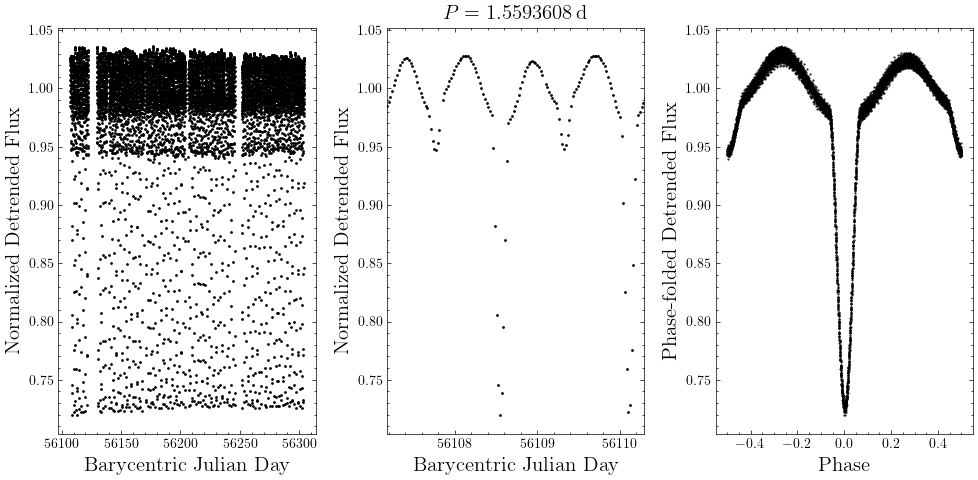

In [187]:
plot_lc(kicid = 6048106 ,period=1.5593608)

The panel on the left shows the full light curve. Dips in the light curve are clearly evident, and upon closer inspection in the middle panel we see that such dips are periodic, that they alternate between a large and a small dip, and they coincide with the troughs of the light curve's sinusoidal variation about a normalized flux value of 1.

The plot on the right shows the light curve folded at its binary period, or the ***phase-folded*** light curve. It reveals the persistent shape of the light curve's variations across time. Let's deconstruct what is seen in this representation:

- The larger dips (centered at zero in the phase-folded representation) are primary eclipses. These correspond to the occultation of the __more__ luminous star by the <u>less</u> luminous star. 
- The smaller dips are secondary eclipses. These correspond to the occultation of the __less__ luminous star by the <u>more</u> luminous star. Because it is customary for phase-folded diagrams to be centered about the primary eclipse within a range of $\pm0.5$ (i.e., one full period), the secondary eclipse here appears truncated as it is centered about a phase of 0.5.
- The ***out-of-transit*** regions of the light curve show the combined luminosity variations of both stars in the system. Here, it demonstrates sinusoidal behaviour due to the rapid rotation of the star and the presence of magnetic activity (starspots) on the surface of members in the binary system. Note the synchronization of the eclipses with the rotation, as expected from close binary stars that tidally interact with one another (they are separated by only 3% of the distance between the Earth and the Sun!).

```{admonition} Phase of the secondary eclipse
:class: seealso
What does the phase of the secondary eclipse tell you about the orbital eccentricity of the binary system? In the above example, is the orbit more eccentric or circular in nature?
```

### Rotating Ellipsoidal Variable

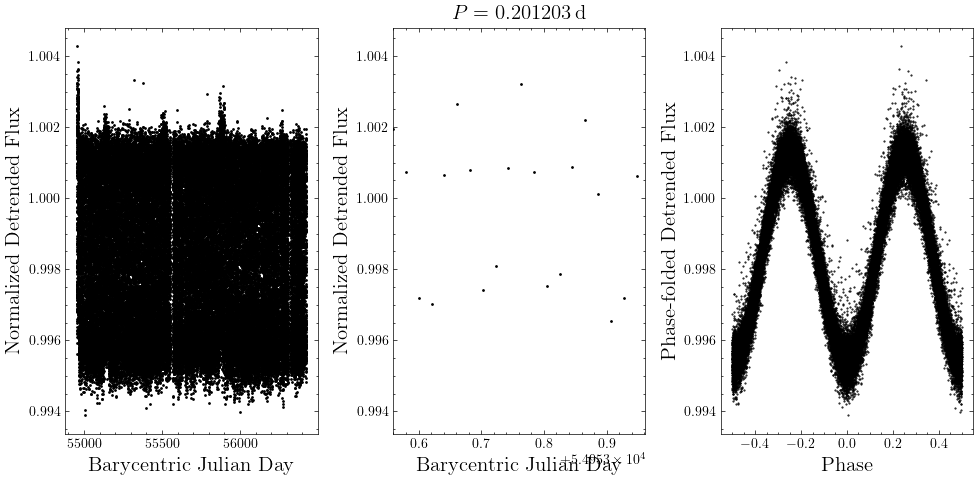

In [190]:
plot_lc(kicid = 6699679 ,period=0.201203)

Technically, this is not an eclipsing system. What is seen here, rather, is the contribution from only one member of the system. However, it has an elongated "teardrop" shape due to the gravitational pull of a closely orbiting binary member. This unique shape causes a varying projection of the star's surface to our line-of-sight as the star rotates, leading to a smooth variation in brightness.

### Contact Binary

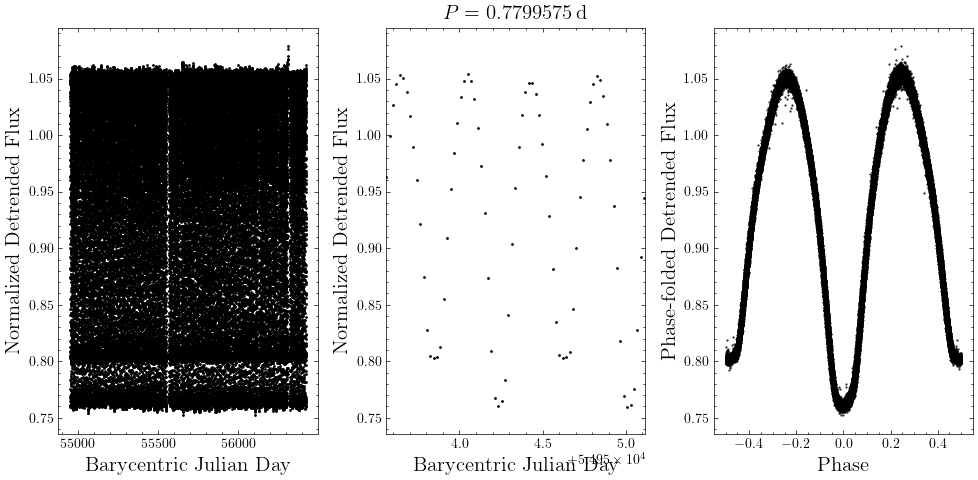

In [194]:
plot_lc(kicid = 8265951 ,period=0.7799575)

Though similar in light curve morphology to ellipsoidal variables, contact binaries are eclipsing systems.

> **Contact Binaries and Ellipsoidal Variables**  
Observe the difference in depth between the troughs at phases of $0$ and $\pm0.5$, as opposed to the ellipsoidal variable example.


The two stars in this system orbit one another so closely that they share a common envelope, meaning they have both filled their Roche lobes. This allows material from one star to flow into the other. Their proximity also produces strong tidal deformations of their individual surfaces which contributes to the overall shape of the combined envelope. As a result, the light curve exhibit a smooth, rounded appearance during out-of-eclipse phases, as the changing projection of the deformed stars' surfaces leads to continuous variations in brightness -- similar to ellipsoidal variables.

### Fully Detached Binary

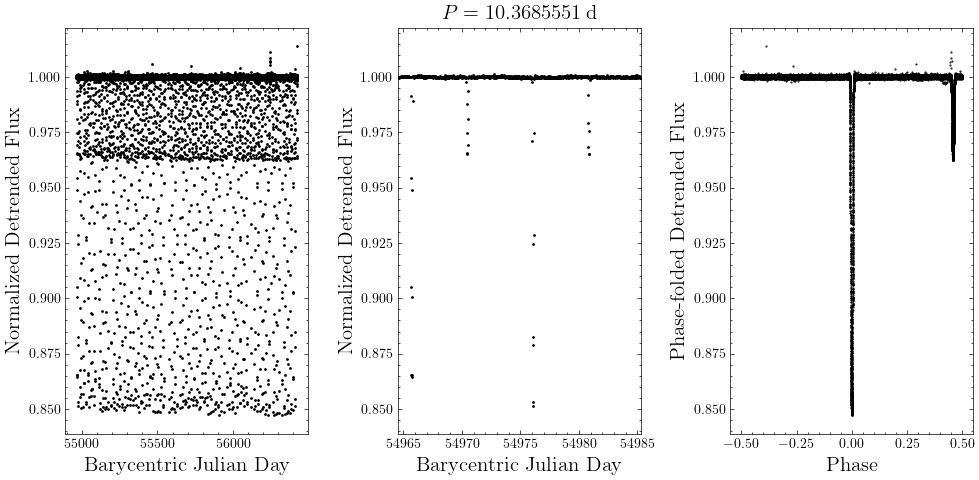

In [241]:
plot_lc(kicid = 11619964 ,period=10.3685551)

Detached binary systems are those whose members are sufficiently separated, such that they do not physically interact. In this example, the out-of-transit light curve shows no signatures of tidal deformation. In some cases where the separation between binary components is sufficiently large, it is possible for the light curve to capture the luminosity variations of a single member alone.


## Formatting the data

The morphology of the binary's eclipses can reveal much about the nature and orbital architecture of the system. The task of exploring and categorizing the binary light curve's morphology is well-suited for machine learning.

To use machine learning for representing the morphology of the phase-folded light curve, it is best to homogenize the input data to a machine learning model. For representations involving light curves, the data is often required to be kept to a fixed length, which implies smoothing or binning the data. 


### Option 1: Binning the data

A straightforward approach is to simply average the flux values into a predetermined grid of phase values, as shown below.

In [514]:
from scipy.stats import binned_statistic

def get_binned_phaselc(phase, flux, num_bins=100):
    phase_bins = np.linspace(min(phase), max(phase), num_bins+1)
    binned_flux, _, _ = binned_statistic(phase, flux, bins=phase_bins, statistic=np.nanmean) 
    return phase_bins, binned_flux

### Option 2: Fitting a smooth, parametric model to the data

Another approach would be to fit a smooth polynomial or spline to the phase-folded light curve.

In [378]:
from scipy.interpolate import UnivariateSpline

def get_smooth_phaselc(phase, flux, num_bins=100, poly_degree=5, spline_smoothing=0.5):
    phase_bins = np.linspace(min(phase), max(phase), num_bins)
    flux, phase = flux[np.argsort(phase)], phase[np.argsort(phase)]
    
    # Fit a polynomial with a pre-specified degree
    coeffs = np.polyfit(phase, flux, poly_degree)
    poly = np.poly1d(coeffs)
    
    flux_poly = poly(phase_bins)
    
    # Fit a spline
    spline = UnivariateSpline(phase, flux, s=spline_smoothing)
    flux_spline = spline(phase_bins)
    
    return phase_bins, flux_poly, flux_spline

Let's observe how these approaches work on our data.

In [ ]:
def plot_binned_lc(kicid, period, num_bins=100):
    kicstr = str(kicid).zfill(8)
    data = pd.read_csv(os.path.join(data_folder_path, f'{kicstr}.00.lc.data'), delim_whitespace=True, comment='#')
    data.columns = ['bjd','phase','raw_flux', 'raw_err', 'corr_flux', 'corr_err', 'dtr_flux','dtr_err']

    phase_bins, binned_flux = get_binned_phaselc(data.phase.values, data.dtr_flux.values, num_bins=num_bins)
    phase_bins_smooth, flux_poly, flux_spline = get_smooth_phaselc(data.phase.values, data.dtr_flux.values, num_bins=num_bins)
    
    fig = plt.figure(figsize=(10, 6))

    fluxes = [binned_flux, flux_poly, flux_spline]
    phases = [0.5*(phase_bins[1:] + phase_bins[:-1]), phase_bins_smooth, phase_bins_smooth]
    labels = ['Binned', 'Polyfit', 'Spline']
    
    axlist = [fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)]
    
    for i, (ax, approx_flux, ph, lbl) in enumerate(zip(axlist, fluxes, phases, labels)):
        ax.scatter(data.phase, data.dtr_flux, s=0.25, c='k')
        ax.scatter(ph, approx_flux, s=5, c='r')
        ax.set_ylabel('Phase-folded Flux', fontsize=fs-3)
        ax.text(x=0.2, y=0.2, transform=ax.transAxes, s=lbl, fontsize=fs-3)
    
    [ax.set_xticklabels([]) for ax in axlist[:2]]
    [ax.set_xlabel('Phase') for ax in axlist[-1:]]
    plt.tight_layout(h_pad=0.2)
    plt.show()

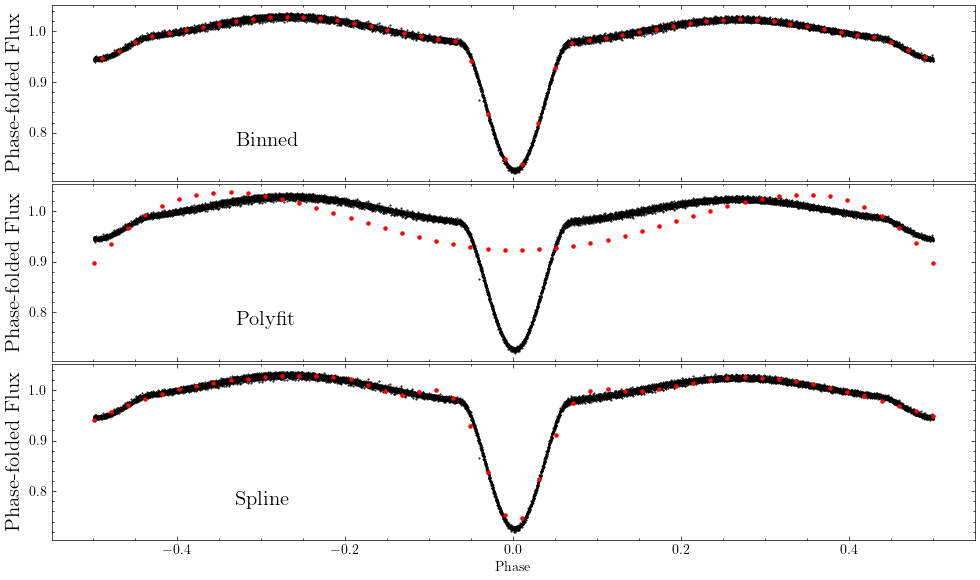

In [401]:
plot_binned_lc(kicid = 6048106 ,period=1.5593608, num_bins=50)

Binning reproduces the shape of the eclipses well, whereas polyfit is certainly too rigid of an approach. Spline fitting looks reasonable at first glance, but is not accurate in capturing sharp features near ingress and egress.

Let's try this on another example: the detached binary.

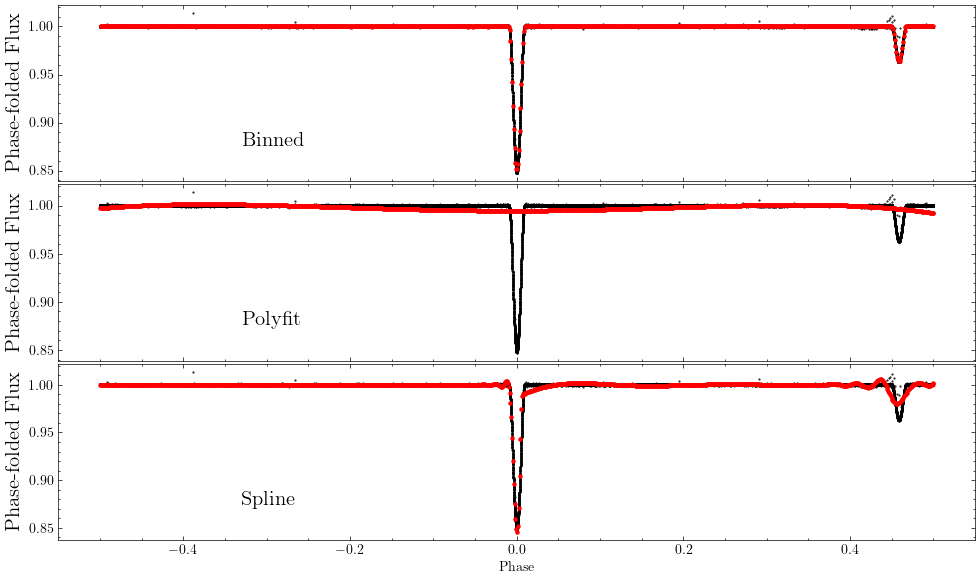

In [437]:
plot_binned_lc(kicid = 11619964 ,period=10.3685551, num_bins=100)

### Option 3: Trend Filtering

Trend filtering is an approach for non-parametric regression, whereby the estimate is the "minimizer of a penalized
least squares criterion, in which the penalty term sums the absolute $k^{\text{th}}$ order discrete derivatives over the input points." {cite}`Tibshirani_2014`. The approach fits a smooth model to the data by solving (e.g., {cite}`Politsch_2020`) 

$$
\begin{aligned}
\\ \min_{m} \sum_{i=1}^n \big( f(t_i)-m(t_i) \big)^2 + \gamma\cdot\text{TV}(m^{(k)}),
\end{aligned}
$$

where $m^{(k)}$ is the $k^{\text{th}}$ derivative of $m$, $\text{TV}(m^{(k)}$ is the ***total variation*** of $m^{(k)}$, and $\gamma > 0 $ controls the smoothness of the fit. 

Briefly, the above creates a piecewise polynomial of degree $k$ with knots selected at a sparse subset of the observed inputs $t_1, \cdots, t_n$. This polynomial has small discontinuities in the derivatives, whose total variation is penalized by some penalty (e.g., $L_1$ or $L_2$ norm). The derivatives $m^{(k)}$ are approximated by the discrete approximation $\Delta^{(k+1)}m(t_i)$, where

$$
\begin{aligned}
\\ \Delta^{(1)}\,m(t_i) &= \frac{m(t_{i+1}) - m(t_i)}{\Delta t} \quad &\text{for}\,k=0, 
\\ \Delta^{(k+1)}\,m(t_i) &= \frac{\Delta^{(k)}m(t_{i+1}) - \Delta^{(k)}m(t_i)}{\Delta t} &\quad \text{for}\,k\geq1. 
\end{aligned}
$$

The following is a simple implementation of such fits for $k\in[0,1,2]$ using the `cvxpy` library.

In [523]:
import cvxpy as cp

def trend_filter_phaselc(phase, flux, flux_err = 1e-2, reg=2, num_bins = 100, k=2):
    phase_bins = np.linspace(min(phase), max(phase), num_bins)
    flux, phase = flux[np.argsort(phase)], phase[np.argsort(phase)]
    
    # Define the optimization variable
    n = len(phase)
    z = cp.Variable(n)

    # Regularization parameter
    lambda_ = reg

    # Penalty
    if k not in [0,1,2]:
        raise ValueError('k must be in [0,1,2]')
    else:
        if k == 0:
            penalty = cp.norm1(z[1:] - z[:-1])
        elif k == 1:
            penalty = cp.norm1(z[2:] - 2*z[1:-1] + z[:-2])
        else:
            penalty = cp.norm1(z[3:] - 3*z[2:-1] + 3*z[1:-2] - z[:-3])

    # Objective: minimize the Huber loss plus L1 penalty on third-order differences
    

    # incorporate uncertainty
    isig = 1 / np.sqrt(flux_err ** 2)
    
    diff = cp.multiply(isig, z - flux)

    objective = cp.Minimize(
        cp.sum(cp.huber(diff)) + lambda_ * penalty
    )

    problem = cp.Problem(objective)
    problem.solve()
    filter_flux = np.interp(phase_bins, phase, z.value)
    
    return phase_bins, filter_flux

Let's observe how this approach compares to the simple binning.

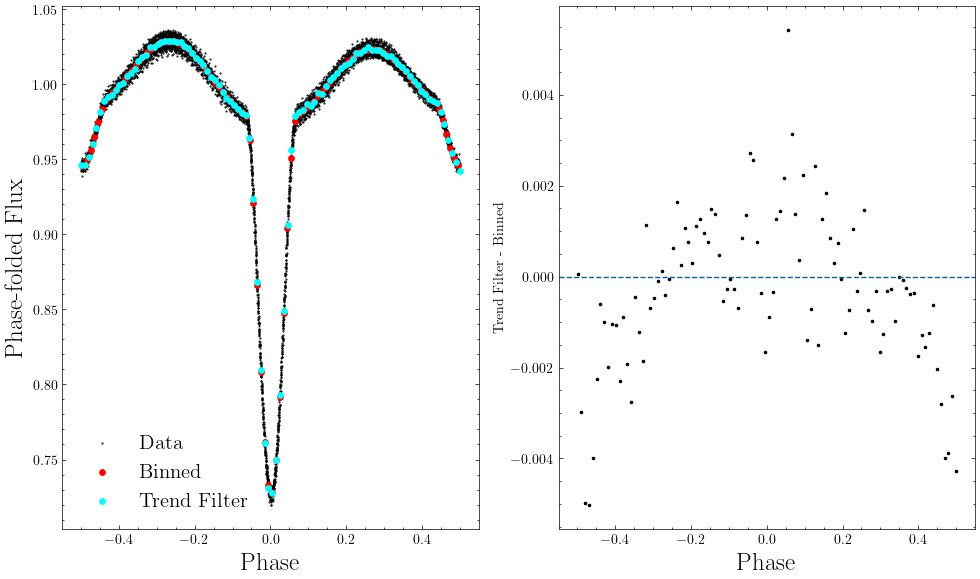

In [524]:
def compare_bin_trend(kicid, period, num_bins=100, k=2, reg = 100):
    kicstr = str(kicid).zfill(8)
    data = pd.read_csv(os.path.join(data_folder_path, f'{kicstr}.00.lc.data'), delim_whitespace=True, comment='#')
    data.columns = ['bjd','phase','raw_flux', 'raw_err', 'corr_flux', 'corr_err', 'dtr_flux','dtr_err']

    phase_bins, binned_flux = get_binned_phaselc(data.phase.values, data.dtr_flux.values, num_bins=num_bins)
    phase_trend, trend_flux = trend_filter_phaselc(data.phase, data.dtr_flux, reg=reg, num_bins = num_bins,
                                                     k = k)    
    fig = plt.figure(figsize=(10, 6))
    
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    ax1.scatter(data.phase, data.dtr_flux, s=0.25, c='k', label='Data')
    ax1.scatter(0.5*(phase_bins[1:] + phase_bins[:-1]), binned_flux, s=15, c='r', label='Binned')
    ax1.scatter(phase_trend, trend_flux, s=15, c='cyan', label='Trend Filter')
    ax1.legend(loc='lower left', prop={'size': fs-3})
    ax1.set_ylabel('Phase-folded Flux', fontsize=fs)
    ax1.set_xlabel('Phase', fontsize=fs)

    ax2.scatter(phase_trend, trend_flux - binned_flux, s=2.5, c='k')
    ax2.set_ylabel('Trend Filter - Binned')
    ax2.axhline(y=0, ls='--')
    ax2.set_xlabel('Phase', fontsize=fs)

    plt.tight_layout(h_pad=0.2)
    plt.show()
    
compare_bin_trend(kicid = 6048106, period=1.5593608, num_bins=100, k=2, reg=100)

In the above example, both methods agree to within a fraction of a percent. Both methods effectively smooth the data and compress it into a more compact representation (fewer phase points). 
The median binning approach, however, is far more efficient computationally. The trend filter is superior in the event that sparse and/or irregular sampling occurs in the data -- this is certainly not exemplified with the pristine _Kepler_ data! 

Let's observe what happens with very few bins:

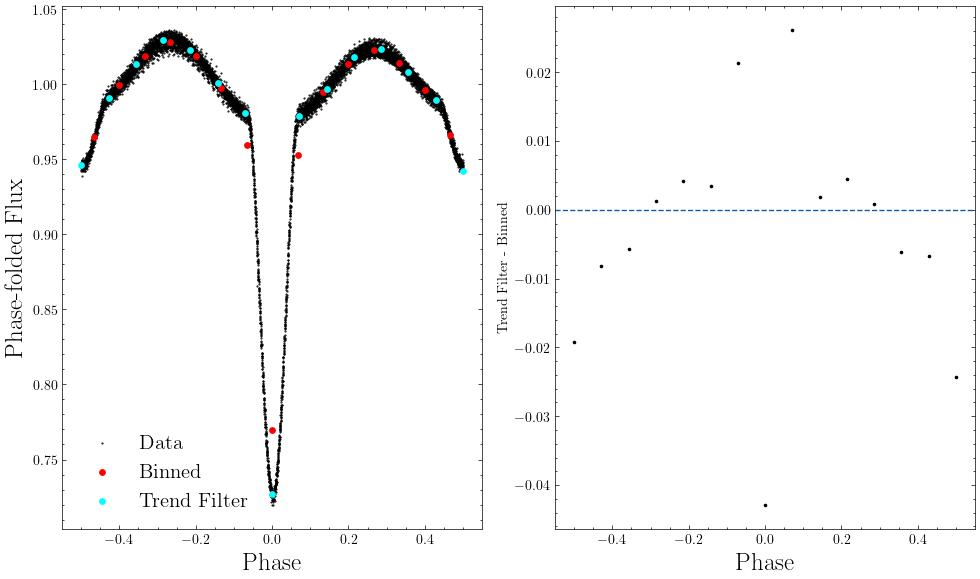

In [525]:
compare_bin_trend(kicid = 6048106, period=1.5593608, num_bins=15, k=2, reg=100)

In this scenario, the median binning approach is highly sensitive to the width of the bins. It effectively "averages" out parts of the eclipse near the wings and at the trough. 

### A less pristine example

Let's examine observations from the ground-based Optical Gravitational Lensing Experiment (OGLE) survey. 

> **The OGLE Survey**  
Established in 1992, the OGLE survey is a Polish long-term sky survey whose main goal is to detect microlensing event. These events occur when a massive object (such as a star, planet, or black hole) passes in front of a distant star, bending and magnifying its light.
>
>At the same time, the survey has measured and cataloged the stellar variability of millions of stars in distant stellar populations residing in the Galactic Bulge and the Magellanic Clouds. The survey observations are publicly [available online](https://ogledb.astrouw.edu.pl/~ogle/OCVS/). 


The following is the observation of [OGLE-LMC-ECL-00125](https://ogledb.astrouw.edu.pl/~ogle/OCVS/getobj.php?s=OGLE-LMC-ECL-00125), a short-period eclipsing binary in the Large Magellanic Cloud.

In [ ]:
data = pd.read_csv(os.path.join(data_folder_path, 'OGLE-LMC-ECL-00125.dat'),
                                delim_whitespace=True, comment='#', header=None)
data.columns = ['time','mag', 'mag_err']
period = 4.325471

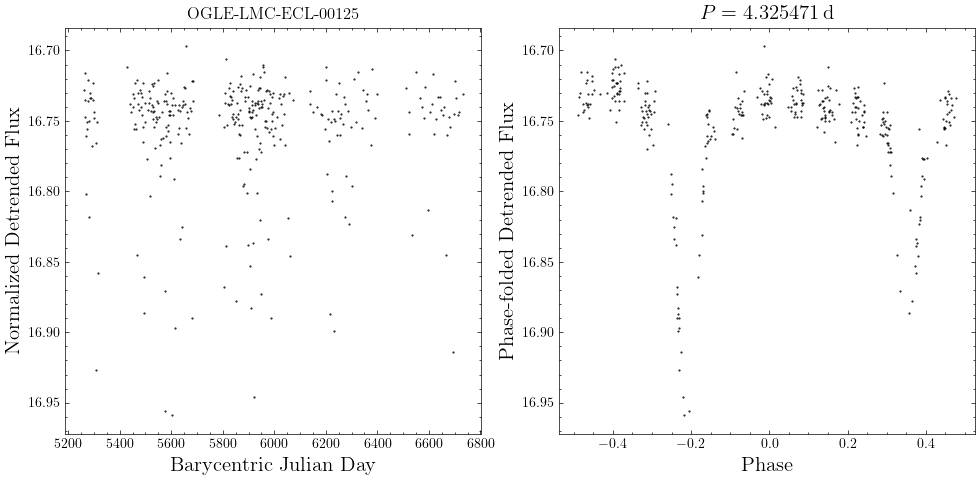

In [460]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax1.scatter(data.time, data.mag, s=0.25, c='k')
ax1.set_xlabel('Barycentric Julian Day', fontsize=fs-3)
ax1.set_ylabel('Normalized Detrended Flux', fontsize=fs-3)
ax1.set_title('OGLE-LMC-ECL-00125')
ax1.invert_yaxis()

phase = np.mod(data.time, period)/period - 0.5
ax2.scatter(phase, data.mag, s=0.25, c='k')
ax2.set_xlabel('Phase', fontsize=fs-3)
ax2.set_ylabel('Phase-folded Detrended Flux', fontsize=fs-3)
ax2.set_title(f'$P={period}\\,$d', fontsize=fs-3)
ax2.invert_yaxis()

plt.tight_layout(h_pad=1)
plt.show()

The trend filtering approach interpolates missing phase coverage due to irregularly sampling much more elegantly than the binning approach. The average of empty bins gives NaNs for the median binning approach, effectively corrupting the input data representation!

> **Trend Filtering vs Binning**  
Another advantage that trend filtering has over binning is the ability to weight data points by their uncertainty. In binning, all measurements are given equal importance regardless of precision, but trend filtering allows naturally prioritizing the most precise measurements when making a smooth fit.

In [ ]:
num_bins = 100
phase_bins, binned_flux = get_binned_phaselc(phase, data.mag, num_bins=num_bins)
phase_trend, trend_flux = trend_filter_phaselc(phase, data.mag, flux_err = data.mag_err, reg=100, num_bins = num_bins,
                                                 k = 2)   

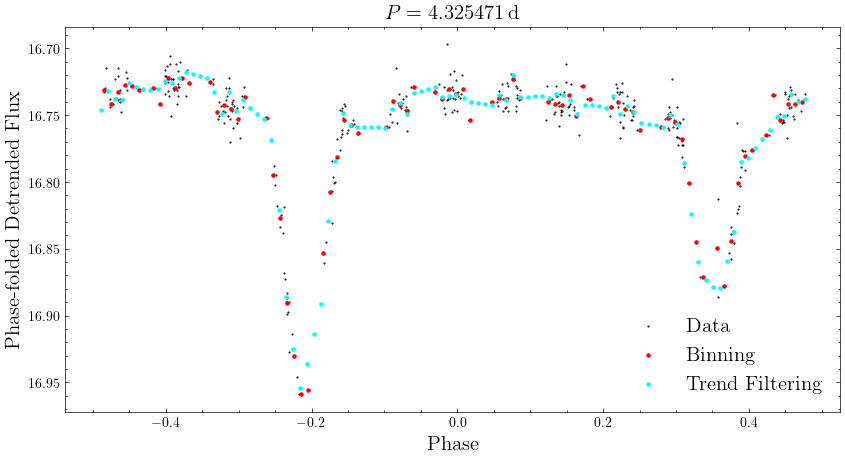

In [526]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(phase, data.mag, s=0.25, c='k', label='Data')
ax1.scatter(0.5*(phase_bins[1:] + phase_bins[:-1]), binned_flux, s=5, c='r', label='Binning')
ax1.scatter(phase_trend, trend_flux, s=5, c='cyan', label='Trend Filtering')

ax1.set_xlabel('Phase', fontsize=fs-3)
ax1.set_ylabel('Phase-folded Detrended Flux', fontsize=fs-3)
ax1.set_title(f'$P={period}\\,$d', fontsize=fs-3)
ax1.invert_yaxis()
ax1.legend(loc='lower right', prop={'size': fs-3})

plt.show()

> **Assignment**
>
> For the stars KIC 6048106, KIC 6699679, and KIC 8265951:
> 
> - Give an estimate of the **minimum** number of bins required to reproduce the shape of the phase folded light curve for the binning method (`get_binned_phaselc`) and the trend filter method (`trend_filter_phaselc`). Plot your results using the `compare_bin_trend` function across **five** values of `num_bins`, including the minimum you found. Which method requires fewer bins in general?
> 
> - Using the **minimum** number of bins for the trend filter method, demonstrate (plot) the effects of varying `k` and `reg`. Vary across three different values each.

